# Project ARI3205 Interpretable AI for Deep Learning Models *(Part 4.0)*
---

**Name:** Andrea Filiberto Lucas  
**ID No:** 0279704L

---

## Importing Necessary Libraries

In [1]:
import json
import os
import subprocess
import warnings
import logging
import absl.logging                                                                                                                                  #type: ignore

# Constants for colored output
COLORS = {
    "green": "\033[92m",  # Green text
    "red": "\033[91m",    # Red text
    "reset": "\033[0m"    # Reset to default color
}

# Path to the JSON file
lib_file_path = os.path.join("..", "Libraries", "Part4_Lib.json")

# Read the libraries from the JSON file
try:
    with open(lib_file_path, 'r') as file:
        libraries = json.load(file)
except FileNotFoundError:
    print(f"{COLORS['red']}Error: Library file not found at {lib_file_path}{COLORS['reset']}")
    exit(1)
except json.JSONDecodeError:
    print(f"{COLORS['red']}Error: Failed to decode JSON from the library file.{COLORS['reset']}")
    exit(1)

# Function to check and install libraries
def check_and_install_libraries(libraries):
    for lib, import_name in libraries.items():
        try:
            # Attempt to import the library
            __import__(import_name)
            print(f"[{COLORS['green']}✔{COLORS['reset']}] Library '{lib}' is already installed.")
        except ImportError:
            # If import fails, try to install the library
            print(f"[{COLORS['red']}✖{COLORS['reset']}] Library '{lib}' is not installed. Installing...")
            try:
                subprocess.check_call(["pip", "install", lib])
                print(f"[{COLORS['green']}✔{COLORS['reset']}] Successfully installed '{lib}'.")
            except subprocess.CalledProcessError:
                print(f"[{COLORS['red']}✖{COLORS['reset']}] Failed to install '{lib}'. Please install it manually.")

# Execute the function to check and install libraries
check_and_install_libraries(libraries)

# Suppress specific warnings
warnings.filterwarnings("ignore")

# Import necessary libraries for data analysis and modeling
import tensorflow as tf                                                                                                                          #type: ignore
import numpy as np                                                                                                                               #type: ignore
import random                                                                                                                                    #type: ignore
import matplotlib.pyplot as plt                                                                                                                  #type: ignore
from tensorflow.keras.layers import (                                                                                                            #type: ignore
    Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator                                                                              #type: ignore
from tensorflow.keras.models import Model,  load_model                                                                                           #type: ignore
from alibi.explainers import IntegratedGradients  # Integrated Gradients explainer                                                               #type: ignore
from alibi.utils.visualization import visualize_image_attr  # Visualization function                                                             #type: ignore

# Display TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")


# Suppress specific warnings
warnings.filterwarnings("ignore")
absl.logging.set_verbosity(absl.logging.ERROR)

[✔] Library 'tensorflow' is already installed.
[✔] Library 'tensorflow_datasets' is already installed.
[✔] Library 'tf_explain' is already installed.
[✔] Library 'numpy' is already installed.
[✔] Library 'matplotlib' is already installed.
[✔] Library 'alibi' is already installed.
TensorFlow Version: 2.18.0


In [2]:
# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10

# Split the dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Training Data Shape: {x_train.shape}, Labels Shape: {y_train.shape}")
print(f"Testing Data Shape: {x_test.shape}, Labels Shape: {y_test.shape}")

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten the label arrays to 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

# Print dataset summary after preprocessing
print(f"Normalized Training Data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Normalized Testing Data: {x_test.shape}, Labels: {y_test.shape}")

Training Data Shape: (50000, 32, 32, 3), Labels Shape: (50000, 1)
Testing Data Shape: (10000, 32, 32, 3), Labels Shape: (10000, 1)
Normalized Training Data: (50000, 32, 32, 3), Labels: (50000,)
Normalized Testing Data: (10000, 32, 32, 3), Labels: (10000,)


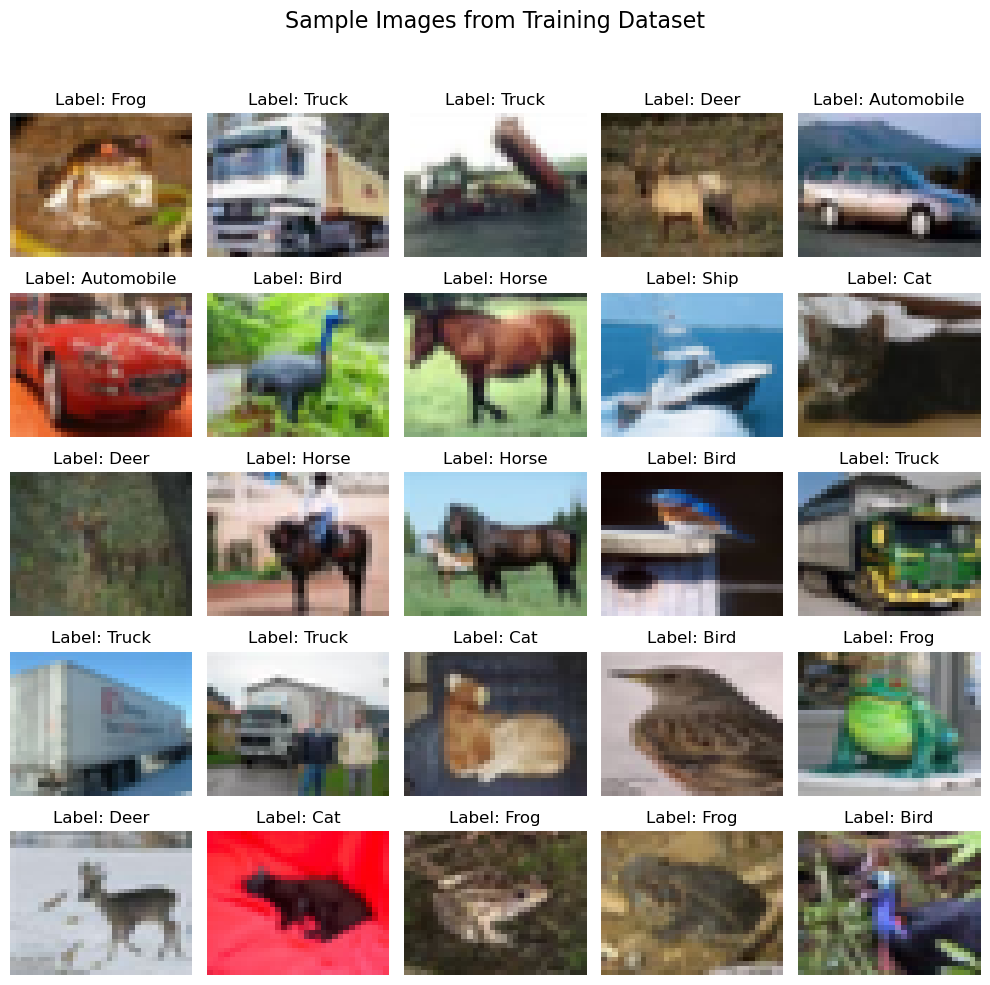

In [3]:
# Define CIFAR-10 class names
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", 
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Visualize sample images from the training dataset
def visualize_images(images, labels, num_rows=5, num_cols=5, class_names=None):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.suptitle("Sample Images from Training Dataset", fontsize=16)
    k = 0

    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(images[k], aspect="auto")
            # Display the class name instead of numeric label
            label_name = class_names[labels[k]] if class_names else labels[k]
            axes[i, j].set_title(f"Label: {label_name}")
            axes[i, j].axis("off")  # Turn off axes for clarity
            k += 1

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Call the function to visualize images with class names
visualize_images(x_train, y_train, class_names=class_names)

In [4]:
# Number of classes based on the unique values in y_train
K = len(set(y_train))
print(f"Number of classes: {K}")

# Build the CNN model using the Functional API
# Input layer
input_layer = Input(shape=x_train[0].shape, name="Input_Layer")

# First Convolutional Block
x = Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv2D_Block1_Layer1")(input_layer)
x = BatchNormalization(name="BatchNorm_Block1_Layer1")(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv2D_Block1_Layer2")(x)
x = BatchNormalization(name="BatchNorm_Block1_Layer2")(x)
x = MaxPooling2D((2, 2), name="MaxPool_Block1")(x)

# Second Convolutional Block
x = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv2D_Block2_Layer1")(x)
x = BatchNormalization(name="BatchNorm_Block2_Layer1")(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv2D_Block2_Layer2")(x)
x = BatchNormalization(name="BatchNorm_Block2_Layer2")(x)
x = MaxPooling2D((2, 2), name="MaxPool_Block2")(x)

# Third Convolutional Block
x = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv2D_Block3_Layer1")(x)
x = BatchNormalization(name="BatchNorm_Block3_Layer1")(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv2D_Block3_Layer2")(x)
x = BatchNormalization(name="BatchNorm_Block3_Layer2")(x)
x = MaxPooling2D((2, 2), name="MaxPool_Block3")(x)

# Flatten the output and add Dropout
x = Flatten(name="Flatten")(x)
x = Dropout(0.2, name="Dropout_Flatten")(x)

# Fully Connected Hidden Layer
x = Dense(1024, activation='relu', name="Dense_Hidden")(x)
x = Dropout(0.2, name="Dropout_Hidden")(x)

# Output Layer
output_layer = Dense(K, activation='softmax', name="Output_Layer")(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer, name="CIFAR10_CNN_Model")

# Print the model summary
model.summary()

Number of classes: 10


Model: "CIFAR10_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Block1_Layer1 (Conv2D)   │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Block1_Layer1         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Block1_Layer2 (Conv2D)   │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Block1_Layer2         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Block1 (MaxPooling2D)   │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Block2_Layer1 (Conv2D)   │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Block2_Layer1         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Block2_Layer2 (Conv2D)   │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Block2_Layer2         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Block2 (MaxPooling2D)   │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Block3_Layer1 (Conv2D)   │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Block3_Layer1         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Block3_Layer2 (Conv2D)   │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Block3_Layer2         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Block3 (MaxPooling2D)   │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Flatten (Dropout)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Hidden (Dropout)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,397,226 (9.14 MB)

 Trainable params: 2,396,330 (9.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [5]:
# Define the directory to check for models
model_dir = os.path.join("..", "Models")

# List available models
available_models = [f for f in os.listdir(model_dir) if f.endswith('.h5')]

if available_models:
    print("Available models:")
    print("0: Train a new model")
    for idx, model_name in enumerate(available_models, start=1):
        print(f"{idx}: {model_name}")

    # Prompt user to select a model
    selected_idx = int(input("Enter the number of the model to load"))

    if selected_idx > 0 and selected_idx <= len(available_models):
        # Load the selected model
        selected_model_path = os.path.join(model_dir, available_models[selected_idx - 1])
        model = load_model(selected_model_path)
        print(f"'{selected_model_path}' loaded successfully.")
    else:
        print("Training a new model...")
        # Ask user for number of epochs
        epochs = int(input("Enter the number of epochs for training: "))

        # Compile the model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Define batch size
        batch_size = 32

        # Data Augmentation for Training Data
        data_generator = ImageDataGenerator(
            width_shift_range=0.1,  # Random horizontal shift
            height_shift_range=0.1,  # Random vertical shift
            horizontal_flip=True     # Random horizontal flip
        )

        # Create a data generator for the training dataset
        train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)

        # Steps per epoch
        steps_per_epoch = x_train.shape[0] // batch_size

        # Train the model using augmented data
        history = model.fit(
            train_generator,
            validation_data=(x_test, y_test),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            verbose=1
        )

        # Plot training and validation accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Save the model with the number of epochs in the filename
        save_path = os.path.join(model_dir, f"AFL_{epochs}.h5")
        model.save(save_path)
        print(f"Model saved successfully at: {save_path}")
else:
    print("No models found. Training a new model...")

    # Ask user for number of epochs
    epochs = int(input("Enter the number of epochs for training: "))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define batch size
    batch_size = 32

    # Data Augmentation for Training Data
    data_generator = ImageDataGenerator(
        width_shift_range=0.1,  # Random horizontal shift
        height_shift_range=0.1,  # Random vertical shift
        horizontal_flip=True     # Random horizontal flip
    )

    # Create a data generator for the training dataset
    train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)

    # Steps per epoch
    steps_per_epoch = x_train.shape[0] // batch_size

    # Train the model using augmented data
    history = model.fit(
        train_generator,
        validation_data=(x_test, y_test),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1
    )

    # Save the model with the number of epochs in the filename
    save_path = os.path.join(model_dir, f"AFL_{epochs}.h5")
    model.save(save_path)
    print(f"Model saved successfully at: {save_path}")


Available models:
0: Train a new model
1: AFL_15T.h5
2: AFL_1T.h5
'../Models/AFL_15T.h5' loaded successfully.


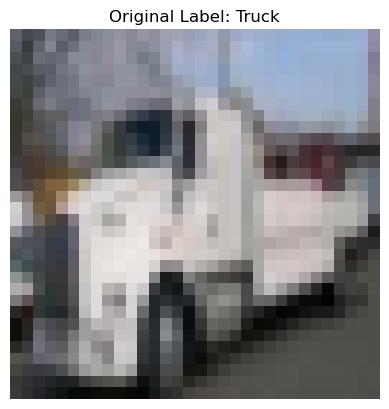

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Original label: Truck
Predicted label: Truck


In [6]:
# Select a random image from the test dataset
image_number = random.randint(0, x_test.shape[0] - 1)

# Display the selected image
plt.imshow(x_test[image_number])
plt.title(f"Original Label: {class_names[y_test[image_number]]}")
plt.axis("off")
plt.show()

# Load the selected image into an array
image_array = np.array(x_test[image_number])

# Reshape the image to match the input shape expected by the model
reshaped_image = image_array.reshape(1, 32, 32, 3)

# Predict the label using the model
predicted_label = class_names[model.predict(reshaped_image).argmax()]

# Load the original label
original_label = class_names[y_test[image_number]]

# Display the result
print(f"Original label: {original_label}")
print(f"Predicted label: {predicted_label}")

In [7]:
# Set up Integrated Gradients
n_steps = 50
method = "gausslegendre"
internal_batch_size = 50
ig = IntegratedGradients(
    model,
    n_steps=n_steps,
    method=method,
    internal_batch_size=internal_batch_size
)

Selected instance index: 9447


2025-01-07 16:18:38.396672: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


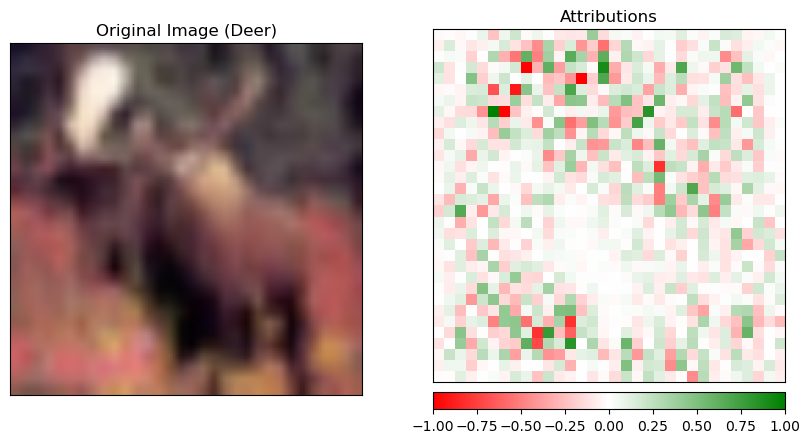

<Figure size 640x480 with 0 Axes>

In [9]:
# Select a random instance to explain
i = random.randint(0, len(x_test) - 1)  # Random index from the test dataset
print(f"Selected instance index: {i}") # Preferred Indexes: 2864, 2003, 4028, 86644, 91, 2741, 5238, 5441, 98
instance = np.expand_dims(x_test[i], axis=0)

# Use the true class label as the target
true_label = int(y_test[i])  # Ensure the target is an integer

# Generate attributions using Integrated Gradients
baseline = np.zeros(instance.shape)  # Black image as baseline
explanation = ig.explain(instance, baselines=baseline, target=true_label)
attrs = explanation.attributions[0]  # Get the attributions for the selected instance

# Upscale the original image for better visualization (optional)
original_image = tf.image.resize(x_test[i], size=(128, 128)).numpy()

# Visualize original image and attributions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Visualize the original image
visualize_image_attr(
    attr=None,
    original_image=original_image,
    method='original_image',
    title=f'Original Image ({class_names[true_label]})',
    plt_fig_axis=(fig, ax[0]),
    use_pyplot=False
)

# Visualize the attributions
visualize_image_attr(
    attr=attrs.squeeze(),
    original_image=original_image,
    method='heat_map',
    sign='all',  # Show both positive and negative contributions
    show_colorbar=True,
    title='Attributions',
    plt_fig_axis=(fig, ax[1]),
    use_pyplot=True
)

plt.tight_layout()
plt.show()